In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import string
from string import digits
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load Data

In [3]:
#load text file data into Dataframe
data = pd.read_table('french.txt', names=["English", "French"])

SIZE = 10000 #@param{type:'slider', min:1000, max:149861, step:1000}
data = data[:SIZE]
#display random rows
data.sample(5)

,English,French
8564,We must escape.,Il nous faut nous échapper.
4668,Have a cookie.,Prends un biscuit !
5350,I'm depressed.,Je suis déprimé.
7887,It's not right.,Ce n'est pas exact.
1987,I feel cold.,J'ai froid.


In [4]:
#lets check out total number of sentences/rows in data
len(data) 

10000

## Data preprocessing

In [5]:
#convert all sentences into lower case.
data.English = data.English.apply(lambda x : x.lower())
data.French = data.French.apply(lambda x : x.lower())

In [6]:
#remove punctuation from sentences
punctuations = set(string.punctuation)
data.English = data.English.apply(lambda x: "".join(letter for letter in x if letter not in punctuations))
data.French = data.French.apply(lambda x: "".join(letter for letter in x if letter not in punctuations))

In [7]:
#convert all digits into None from sentences
digit_remover = str.maketrans('','',digits)
data.English = data.English.apply(lambda x : x.translate(digit_remover))
data.French = data.French.apply(lambda x : x.translate(digit_remover))

In [8]:
data.sample(5)

,English,French
7280,i left my wife,jai quitté ma femme
629,im armed,je suis armée
4567,do you see me,me voyezvous
1104,i can jump,je peux sauter
8373,this is a fact,cest un fait


In [9]:
#Apply "START" & "END" token in french sentences
data.French = data.French.apply(lambda x : "START"+ " " + x +" " +"END")

In [10]:
data.head()

,English,French
0,go,START va END
1,run,START cours END
2,run,START courez END
3,wow,START ça alors END
4,fire,START au feu END


In [11]:
english_sentences = data.English.values
french_sentences = data.French.values

#Define tokenizer
encoder_tokenizer = Tokenizer(oov_token="<OOV>")
decoder_tokenizer = Tokenizer(oov_token="<OOV>")

#fit all sentences into tokenizer
encoder_tokenizer.fit_on_texts(english_sentences)
decoder_tokenizer.fit_on_texts(french_sentences)

In [12]:
#get word indeces
encoder_word_index = encoder_tokenizer.word_index
decoder_word_index = decoder_tokenizer.word_index

In [13]:
#convert sentences into sequences
encoder_sequences = encoder_tokenizer.texts_to_sequences(english_sentences)
decoder_sequences = decoder_tokenizer.texts_to_sequences(french_sentences)

In [14]:
#lets find max length of sentences
lengths = list()
for sentence in english_sentences:
  lengths.append(len(sentence.split()))
max_encoder_length=np.max(lengths)

lengths = list()
for sentence in french_sentences:
  lengths.append(len(sentence.split()))
max_decoder_length=np.max(lengths)

print("Max encoder length => ",max_encoder_length)
print("Max decoder length => ",max_decoder_length)

Max encoder length =>  5
Max decoder length =>  12


In [15]:
#pad sequences with 0s
encoder_input_data = pad_sequences(encoder_sequences, padding='post')
decoder_input_data = pad_sequences(decoder_sequences, padding='post')

In [16]:
#display any sentence and corresponding sequence and padded sequence
print("sentence : ", english_sentences[1000])
print('sequence : ', encoder_sequences[1000])
print('sequence : ', encoder_input_data[1000])
print("default length of sequence : ", len(encoder_input_data[1000]))

sentence :  come alone
sequence :  [37, 96]
sequence :  [37 96  0  0  0]
default length of sequence :  5


In [17]:
decoder_output_data = []
for seq in decoder_input_data:
  temp = []
  for number in seq: 
    one_hot = np.zeros(len(decoder_word_index), dtype='float32')
    if number!=0:
      one_hot[number-1] = float(1)
    temp.append(one_hot)
  decoder_output_data.append(temp)
decoder_output_data = np.array(decoder_output_data)

In [18]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_output_data.shape)
print(len(encoder_word_index))
print(len(decoder_word_index))

(10000, 5)
(10000, 12)
(10000, 12, 4837)
2146
4837


In [19]:
#display any sentence and corresponding sequence and padded sequence
print("sentence : ", french_sentences[1000])
print('sequence : ', decoder_sequences[1000])
print('sequence : ', decoder_input_data[1000])
print("default length of sequence : ", len(decoder_input_data[1000]))
print("one-hot of sequence : ", decoder_output_data[1000])

sentence :  START venez seule  END
sequence :  [2, 146, 323, 3]
sequence :  [  2 146 323   3   0   0   0   0   0   0   0   0]
default length of sequence :  12
one-hot of sequence :  [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Model Development

In [20]:
#hyperparameters
embedding_size = 120
lstm_dim = 364

#parameters
encoder_vocab_size = len(encoder_word_index)
decoder_vocab_size = len(decoder_word_index)
#input_shape = (max_encoder_length,)

In [21]:
#building model 
#Encoder model
encoder_input = Input(shape=(None,))
E_x = Embedding(encoder_vocab_size+1, embedding_size)(encoder_input)
encoder = LSTM(lstm_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(E_x)
encoder_states = [state_h, state_c]

#decoder model
decoder_input = Input(shape=(None,))
decoder_E_x = Embedding(decoder_vocab_size+1, embedding_size)(decoder_input)
decoder_lstm = LSTM(lstm_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_E_x, initial_state=encoder_states)
decoder_dense= Dense(decoder_vocab_size, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [22]:
model = Model([encoder_input, decoder_input], decoder_outputs)

In [23]:
model.compile(optimizer="rmsprop",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 120)    257640      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 120)    580560      ['input_2[0][0]']                
                                                                                              

In [25]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_output_data, batch_size=64, epochs=100)

Epoch 1/100
157/157 [==============================] - 15s 37ms/step - loss: 2.0750 - accuracy: 0.1711
Epoch 2/100
157/157 [==============================] - 6s 36ms/step - loss: 1.8108 - accuracy: 0.2060
Epoch 3/100
157/157 [==============================] - 6s 35ms/step - loss: 1.6356 - accuracy: 0.2339
Epoch 4/100
157/157 [==============================] - 6s 35ms/step - loss: 1.4517 - accuracy: 0.2617
Epoch 5/100
157/157 [==============================] - 6s 35ms/step - loss: 1.2204 - accuracy: 0.2894
Epoch 6/100
157/157 [==============================] - 5s 35ms/step - loss: 1.0314 - accuracy: 0.3048
Epoch 7/100
157/157 [==============================] - 5s 35ms/step - loss: 0.8919 - accuracy: 0.3180
Epoch 8/100
157/157 [==============================] - 6s 35ms/step - loss: 0.7825 - accuracy: 0.3306
Epoch 9/100
157/157 [==============================] - 6s 35ms/step - loss: 0.6896 - accuracy: 0.3408
Epoch 10/100
157/157 [==============================] - 5s 35ms/step - loss: 0.60

KeyError: ignored

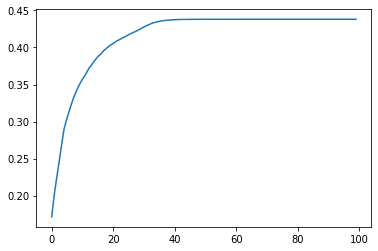

In [26]:
import matplotlib.pyplot as plt
def plot_graph(history, string):
  x = np.arange(0,100)
  plt.plot(x, history.history[string], label=string)
  plt.plot(x, history.history["val_"+string], label="val_"+string)
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()

plot_graph(history, "accuracy")
plot_graph(history, "loss")

In [27]:
#Inference Stage

#encoder model
encoder_model = Model(encoder_input, encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 120)         257640    
                                                                 
 lstm (LSTM)                 [(None, 364),             706160    
                              (None, 364),                       
                              (None, 364)]                       
                                                                 
Total params: 963,800
Trainable params: 963,800
Non-trainable params: 0
_________________________________________________________________


In [28]:
#decoder model
decoder_state_input_h = Input(shape=(lstm_dim,))
decoder_state_input_c = Input(shape=(lstm_dim,))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

final_dex2 = Embedding(decoder_vocab_size, embedding_size)(decoder_input)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex2, initial_state=decoder_state_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_input] + decoder_state_inputs, [decoder_outputs2] + decoder_states2)

In [29]:
# reversing the word index dictionary to get words from index values
reverse_input_char_index = dict((i,char) for char, i in encoder_word_index.items())
reverse_output_char_index = dict((i,char) for char, i in decoder_word_index.items())
print(reverse_input_char_index)


{1: '<OOV>', 2: 'i', 3: 'you', 4: 'it', 5: 'im', 6: 'a', 7: 'is', 8: 'he', 9: 'are', 10: 'me', 11: 'tom', 12: 'we', 13: 'youre', 14: 'go', 15: 'were', 16: 'its', 17: 'was', 18: 'dont', 19: 'do', 20: 'be', 21: 'to', 22: 'this', 23: 'that', 24: 'can', 25: 'not', 26: 'ill', 27: 'the', 28: 'up', 29: 'have', 30: 'they', 31: 'did', 32: 'she', 33: 'like', 34: 'here', 35: 'am', 36: 'no', 37: 'come', 38: 'get', 39: 'him', 40: 'my', 41: 'hes', 42: 'all', 43: 'in', 44: 'let', 45: 'thats', 46: 'your', 47: 'need', 48: 'got', 49: 'love', 50: 'us', 51: 'how', 52: 'stop', 53: 'well', 54: 'look', 55: 'out', 56: 'want', 57: 'who', 58: 'feel', 59: 'cant', 60: 'what', 61: 'take', 62: 'theyre', 63: 'on', 64: 'hate', 65: 'one', 66: 'toms', 67: 'know', 68: 'see', 69: 'home', 70: 'must', 71: 'so', 72: 'help', 73: 'back', 74: 'now', 75: 'please', 76: 'stay', 77: 'good', 78: 'busy', 79: 'felt', 80: 'just', 81: 'saw', 82: 'had', 83: 'lost', 84: 'too', 85: 'happy', 86: 'try', 87: 'leave', 88: 'give', 89: 'her', 9

In [30]:
def decode_seq(input_seq):
  state_values = encoder_model.predict(input_seq)

  target_seq = np.zeros((1,1))

  target_seq[0,0] = decoder_word_index['start']

  stop_condition = False
  decoded_sentence = ''

  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + state_values)

    sampled_token_index = np.argmax(output_tokens[0,-1,:])
    sampled_char = reverse_output_char_index[sampled_token_index]

    decoded_sentence += ' ' + sampled_char

    if(sampled_char == 'end' or len(decoded_sentence) > 52):
      stop_condition = True

    target_seq = np.zeros((1,1))
    target_seq[0,0] = sampled_token_index

    state_values = [h,c] 

  return decoded_sentence

In [34]:
# testing the model for a sample from existing data
for seq_index in [1234, 4356, 4565, 34, 2345, 7656]:
  input_seq = encoder_input_data[seq_index:seq_index+1]
  decoded_sentence = decode_seq(input_seq)
  print('----')
  print('Input_sentence: ', data.English[seq_index:seq_index+1])
  print('French sentence: ', decoded_sentence)

----
Input_sentence:  1234    i wrote it
Name: English, dtype: object
French sentence:   <OOV> tomates tomates opération tomates plierai plierai
----
Input_sentence:  4356    youre funny
Name: English, dtype: object
French sentence:   dimbécile  imprudents lemportes attardés mourut mourut
----
Input_sentence:  4565    do you get it
Name: English, dtype: object
French sentence:   cancer maimes  sagissaitil détestes décroche bien  cinq
----
Input_sentence:  34    got it
Name: English, dtype: object
French sentence:   <OOV> vienstu magnifique  connus incroyables incroyables
----
Input_sentence:  2345    is tom well
Name: English, dtype: object
French sentence:   <OOV> parvienstu connait peuton fraternité fraternité
----
Input_sentence:  7656    im interested
Name: English, dtype: object
French sentence:   <OOV> approche plierai plierai plierai plierai plierai
